# Notebook Practice

In case you do not dispose from a local environment please launch this repository from 

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/aladinoster/datascience-exercises/HEAD?labpath=notebook-practice.ipynb) 
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aladinoster/datascience-exercises/blob/main/notebook-practice.ipynb)

## Situational description 

Within the folder `data/` you will find multiple files containing events from  a time series, this events correspond to messages received from trains 
where each line corresponds to an event registred by the train. 

1. For this case only few codes have been selected.
2. A regular table contains the following structure:

| Date       | Hour    | State | Code                   | Train | CarNumber | Equipement | Pressure |
|------------|----------|-------|------------------------|-------|-----------|------------|----------|
| 2022-11-01 | 23:52:18 | App   | Pressure | TR_105 | C5        | 3D         | 2.94     |

Where corresponds to: 
- `Date`  the date of the event
- `Hour`  the hour of the event
- `State` a binary value determining wether the event has appeared or dissappeared. This means the event has a duration that can be computed 
  between the arrival (App) and its subsequent dissapeareance (Disp)
- `Code`  the code concerned
- `Train` the involved Train
- `CarNumber` the involved wagon
- `Equipement` the impacted equipement within the wagon. (For example a specific door of a wagon)

### Questions to Answer 

Extract information within the files into a `DataFrame` and examine the following questions:

1. How many trains are observed? 
2. Which are the potential wagon names? 
3. What are the name of the different equipements found in the dataset? 
4. Which periods of time are involved within the analysis?
5. Which is the `Code` which is more frequently sent? 
6. How many messages per day can be observed along the whole fleet?
7. Which is the average time between the arrival and the disappearence of an event?
8. What is the average pressure per day along the fleet? (Plot this timeseries)
9. In case you can propose to forecast ahead the pressure what would this be? 
10. Implement this model!

In [38]:
%pip install pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


1. How many trains are observed? 

In [43]:
import pandas as pd 
from pathlib import Path 

p = Path(".") / "data"
df = pd.concat(
    [pd.read_csv(f, index_col=False) for f in p.glob("file*.csv")],
    ignore_index=True
)
df = df.iloc[:,1:]
len(df.Train.unique())
df

,Date,Hour,State,code,Train,CarNumber,Equipement,Pressure
0,2022-01-01,23:48:19,Disp,Door,106TR_,C3,3G,2.91
1,2022-01-01,23:48:14,App,Door,106TR_,C3,3G,2.9
2,2022-01-01,23:40:04,App,Pressure,76TR_,T,-,-
3,2022-01-01,23:40:04,Disp,Pressure,76TR_,T,-,-
4,2022-01-01,23:34:22,App,Door,46TR_,C2,2D,2.89
...,...,...,...,...,...,...,...,...
311184,2022-02-28,00:01:54,App,DoorGeneral,89TR_,T,-,2.86
311185,2022-02-28,00:01:54,App,Door,89TR_,C2,1G,2.86
311186,2022-02-28,00:01:54,App,Door,89TR_,C2,2G,2.86
311187,2022-02-28,00:01:54,App,Door,89TR_,C2,3G,2.86


2. Which are the potential wagon names? 

In [44]:
df.code.unique()

array(['Door', 'Pressure', 'DoorGeneral', 'SlowDoor'], dtype=object)

3; What are the name of the different equipements found in the dataset? 

In [45]:
df.Equipement.unique()

array(['3G', '-', '2D', '1D', '3D', '1G', '2G'], dtype=object)

4. Which periods of time are involved within the analysis?


In [46]:
pd.to_datetime(df.Date).describe().loc[["min","max"]]

min    2022-01-01 00:00:00
max    2022-06-30 00:00:00
Name: Date, dtype: object

5. Which is the `Code` which is more frequently sent? 

In [47]:
df.code.value_counts(normalize=True).head(1)

code
Door    0.681618
Name: proportion, dtype: float64

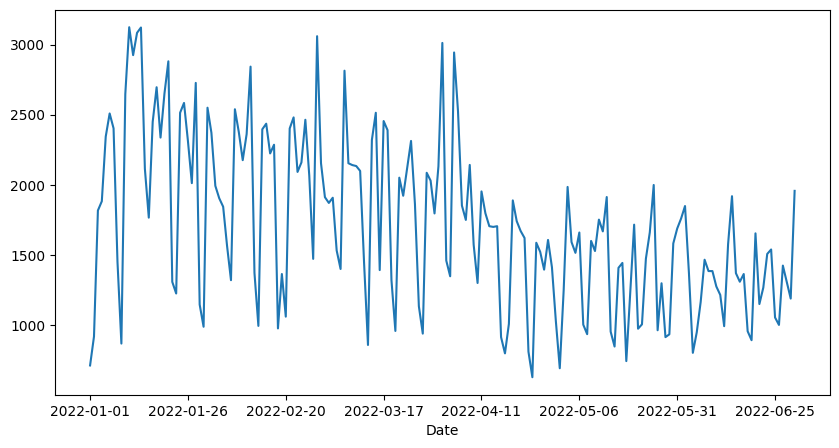

In [48]:
from matplotlib import pyplot as plt 
f, ax = plt.subplots(figsize=(10,5))
ax = df.groupby(["Date"])["code"].count().plot(ax=ax);

7. Which is the average time between the arrival and the disappearence of an event?

In [77]:
app = df[df["State"]=="App"].copy()
app["Hour"] = app["Hour"].astype('timedelta64[s]')
dsp = df[df["State"]=="Disp"].copy()
dsp["Hour"] = dsp["Hour"].astype("timedelta64[s]")

df_delta = pd.merge_asof(
    app.drop(columns="Pressure").sort_values("Hour"),
    dsp.drop(columns="Pressure").sort_values("Hour").assign(time = lambda x: x["Hour"]),
    by=["Date", "Train","CarNumber","Equipement","code"],
    on="Hour",
    direction="forward",
    suffixes=("","_dsp")
)

df_delta["delta"] = df_delta["time"] - df_delta["Hour"]
df_delta["delta"].describe()

count             155541
mean     0 days 00:00:31
std      0 days 00:07:18
min      0 days 00:00:00
25%      0 days 00:00:00
50%      0 days 00:00:01
75%      0 days 00:00:02
max      0 days 11:43:52
Name: delta, dtype: object

8. What is the average pressure per day along the fleet? (Plot this timeseries)


<Axes: xlabel='Date'>

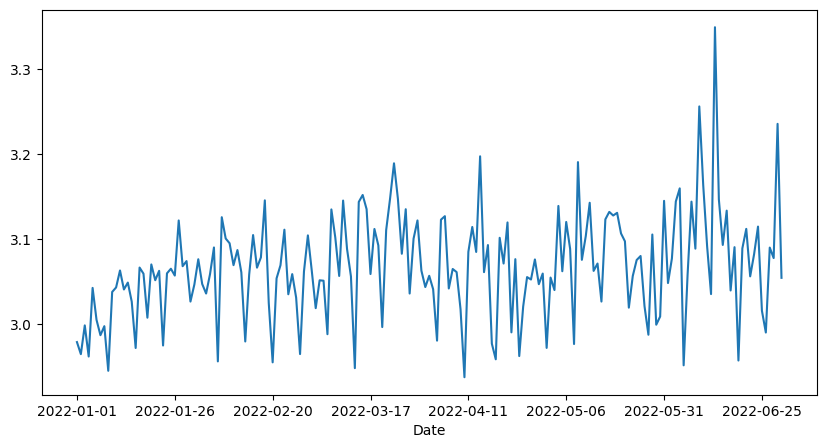

In [86]:
import numpy as np
f, ax = plt.subplots(figsize=(10,5))
df.replace({"-":np.nan}).astype({"Pressure":"float64"}).groupby("Date")["Pressure"].mean().plot(ax=ax)

9. In case you can propose to forecast ahead the pressure what would this be? 
10. Implement this model!